# ML Iterations

## Custom transformers

In [ ]:
class TimeFeatures(BaseEstimator, TransformerMixin):

    def __init__(self, time_column, time_zone_name='America/Los_Angeles'):
        self.time_column = time_column
        self.time_zone_name = time_zone_name

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        assert isinstance(X, pd.DataFrame)

        X.index = pd.to_datetime(X[self.time_column])
        X.index = X.index.tz_convert(self.time_zone_name)
        X["hour"] = X.index.hour
        return X[[
                'hour',
            ]].reset_index(drop=True)

## Distance custom transformer

In [ ]:
class DistanceTransformer(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        assert isinstance(X, pd.DataFrame)

        X['distance'] = minkowski_distance(X, p=1)
        return X[[
                'distance',
            ]]

## Pipeline

feat engineering

In [ ]:
pipe_time = make_pipeline(TimeFeatures(time_column='pickup_datetime')\
                                      , StandardScaler())
pipe_distance = make_pipeline(DistanceTransformer(), RobustScaler())

# column transformer
dist_cols = ['pickup_latitude', 'pickup_longitude',\
             'dropoff_latitude', 'dropoff_longitude']
time_cols = ['pickup_datetime']

feat_eng_bloc = ColumnTransformer([('time', pipe_time, time_cols),
                                  ('distance', pipe_distance, dist_cols)]
                                  ) # remainder='passthrough'

# workflow
pipe_cols = Pipeline(steps=[('feat_eng_bloc', feat_eng_bloc),
                            ('regressor', RandomForestRegressor())])

pipe_cols.fit(X_train, y_train)

## Using a MLflow server on your machine

In [ ]:
pip install mlflow

👉 Fine if you are training your model on your machine

⚠️ MLflow will store the data in a mlruns directory. mlruns will be created in the directory in which the tracking code is launched (for example at the location of the notebook, not at the location where jupyter notebook is launched)

### Record the performance of your trainings locally

In [ ]:
from  mlflow.tracking import MlflowClient

EXPERIMENT_NAME = "model_experiment"

client = MlflowClient()
experiment_id = client.create_experiment(EXPERIMENT_NAME)

for model in ["linear", "Randomforest"]:
    run = client.create_run(experiment_id)
    client.log_metric(run.info.run_id, "rmse", 4.5)
    client.log_param(run.info.run_id, "model", model)

In [ ]:
! mlflow ui # to check

### Record it on server (LeWagon)

In [ ]:
import mlflow
from  mlflow.tracking import MlflowClient

mlflow.set_tracking_uri("https://mlflow.lewagon.co/")

EXPERIMENT_NAME = "[country initials] [city] [login] model name + version"

client = MlflowClient()
experiment_id = client.create_experiment(EXPERIMENT_NAME)

for model in ["linear", "Randomforest"]:
    run = client.create_run(experiment_id)
    client.log_metric(run.info.run_id, "rmse", 4.5)
    client.log_param(run.info.run_id, "model", model)

## Integrating ML Flow into package

In [ ]:
from memoized_property import memoized_property

import mlflow
from  mlflow.tracking import MlflowClient

class Trainer():
    MLFLOW_URI = "https://mlflow.lewagon.co/"

    def __init__(self, experiment_name):
        self.experiment_name = experiment_name

    @memoized_property
    def mlflow_client(self):
        mlflow.set_tracking_uri(self.MLFLOW_URI)
        return MlflowClient()

    @memoized_property
    def mlflow_experiment_id(self):
        try:
            return self.mlflow_client.create_experiment(self.experiment_name)
        except BaseException:
            return self.mlflow_client.get_experiment_by_name(self.experiment_name).experiment_id

    def mlflow_create_run(self):
        self.mlfow_run = self.mlflow_client.create_run(self.mlflow_experiment_id)

    def mlflow_log_param(self, key, value):
        self.mlflow_client.log_param(self.mlfow_run.info.run_id, key, value)

    def mlflow_log_metric(self, key, value):
        self.mlflow_client.log_metric(self.mlfow_run.info.run_id, key, value)

    def train(self):

        for model in ["linear", "Randomforest"]:
            self.mlflow_create_run()
            self.mlflow_log_metric("rmse", 4.5)
            self.mlflow_log_param("model", model)

trainer = Trainer("[FR] [Paris] [gman] DE D3 model_experiment 6")
trainer.train()

# Train at Scale

## Send commands to GCP

include the following IN the package´s MAKEFILE specifiying
the content of the curly brackets

e.g. with the taxifare package

In [ ]:
JOB_NAME=taxifare_training_$(shell date + '%Y%m%d_%H%M%S')
BUCKET_NAME=wagon-data-735-castoldie
BUCKET_TRAINING_FOLDER=trainings
PACKAGE_NAME=taxifare
FILENAME=trainer
PYTHON_VERSION=3.7
RUNTIME_VERSION=2.2
REGION=europe-west3

gcloud --help
gcloud ai-platform jobs submit training ${JOB_NAME} \
    --job-dir gs://${BUCKET_NAME}/${BUCKET_TRAINING_FOLDER}  \
    --package-path ${PACKAGE_NAME} \
    --module-name ${PACKAGE_NAME}.${FILENAME} \
    --python-version=${PYTHON_VERSION} \
    --runtime-version=${RUNTIME_VERSION} \
    --region ${REGION} \
    --stream-logs

## MANIFEST.in

In [ ]:
include requirements.txt
graft taxifare
global-exclude *.py[cod] __pycache__*.so*.ipynb

## Quick wins for memory optimization

In [ ]:
def df_optimized(df, verbose=True, **kwargs):
    """
    Reduces size of dataframe by downcasting numerical columns
    :param df: input dataframe
    :param verbose: print size reduction if set to True
    :param kwargs:
    :return:
    """
    in_size = df.memory_usage(index=True).sum()
    for type in ["float", "integer"]:
        l_cols = list(df.select_dtypes(include=type))
        for col in l_cols:
            df[col] = pd.to_numeric(df[col], downcast=type)
            if type == "float":
                df[col] = pd.to_numeric(df[col], downcast="integer")
    out_size = df.memory_usage(index=True).sum()
    ratio = (1 - round(out_size / in_size, 2)) * 100
    GB = out_size / 1000000000
    if verbose:
        print("optimized size by {} % | {} GB".format(ratio, GB))
    return df

### Downcasting variable types

In [ ]:
import pandas as pd
df = pd.DataFrame(dict(a=[1, 2, 3333]))
df.dtypes

In [ ]:
pd.to_numeric(df.a, downcast='integer')

# Prediction in production

## Fast API

👉 High performance python framework

👉 Easy to learn, fast to code

👉 Automatically generated documentation allowing to test the API endpoints easily 🎉

In [ ]:
!pip install fastapi

### Root entry point

In [ ]:
from fastapi import FastAPI

app = FastAPI()

# define a root `/` endpoint
@app.get("/")
def index():
    return {"ok": "Hi class!"}

What if we run the code?

In [ ]:
python -m simple

Nothing happens... 🤔

## Uvicorn

Uvicorn listens to all the HTTP requests and calls the code decorated for the corresponding FastAPI endpoints.

!pip install uvicorn

In [ ]:
uvicorn simple:app --reload

Now we can browse to the root page of the API: http://localhost:8000/
            or 127.0.0.1:8000

### Ask for prediction

To ask for a prediction, our API should be able to accept a HTTP request with params:

In [ ]:
url = 'http://localhost:8000/predict'
params = {
    'day_of_week': 0, # 0 for Sunday, 1 for Monday, ... 
    'time': '14:00'
}
response = requests.get(url, params=params)
response.json()
#=> {wait: 64}

### /predict endpoint

Let's add a /predict endpoint to our API

In [ ]:
@app.get("/predict")
def predict():
    return {'wait': 64}

### Query parameters

❓What if you want to pass parameters to the endpoint?

In [ ]:
@app.get("/predict")
def predict(day_of_week, time):
    # compute `wait_prediction` from `day_of_week` and `time`
    return {'wait': wait_prediction}

## Docker

### FROM directive

In [ ]:
FROM python:3.8.6-buster

## Let's build our first image

### Build a docker image
👉 based on the Dockerfile placed in the current directory .

In [ ]:
docker build .

1. List the docker images on the machine


In [ ]:
docker images

2. Run the image


In [ ]:
docker run python:3.8.6-buster

### 4. Let's run our image interactively -it and ask it to run a shell command sh

In [ ]:
docker run -it python:3.8.6-buster sh

ls -la

python --version

👉 but our app is nowhere to be seen 🤔

In [ ]:
exit

In [ ]:
COPY app /app
COPY requirements.txt /requirements.txt

In [ ]:
fastapi
uvicorn

1. Build our new image
👉 name it api -t api

In [ ]:
docker build -t api .

2. Run it interactively

In [ ]:
docker run -it api sh

3. Let's see how our app is doing

In [ ]:
ls -la
cat app/simple.py
cat requirements.txt

👉 see how the files are now inside of the container

In [ ]:
pip freeze
exit

### RUN directive

The RUN directive allows to specify commands that will be executed inside of the image. This might come in handy in order to install the requirements of our packages.

In [ ]:
RUN pip install --upgrade pip
RUN pip install -r requirements.txt

### Let's install our packages

1. Build the latest version of the image
👉 you know the drill

2. Run our container interactively

In [ ]:
pip freeze
exit

3. Everything seems to be ok... Let's run our container!

In [ ]:
docker run api

### CMD directive

The CMD directive is the last directive of the Dockerfile. It allows to specify which command the container should run once it has started.

In [ ]:
CMD uvicorn app.simple:app --host 0.0.0.0

⚠️ The --host 0.0.0.0 uvicorn parameter tells uvicorn to listen to all the network connexions inside of the container. Without this parameter you will not be able to contact your API through uvicorn.

### Finally let's connect to our running container

1. Run the container

In [ ]:
docker run -p 8080:8000 api  # ⚠️ beware to
# the order of these parameters or you will get a weird error

👉 Parameters:

In [ ]:
-p 8080:8000 # maps the 8080 port on your machine to the 8000 port 
# inside of the container

2. Connect to our API

In [ ]:
http://localhost:8080/

### How to stop a container

1. List the running containers

In [ ]:
docker ps

2. Stop the image
👉 use the correct CONTAINER ID

In [ ]:
docker stop 152e5b79177b

3. If you are in a hurry
👉 use with caution, only if the image refuses to stop

In [ ]:
docker kill 152e5b79177b

## Container Registry

### Parameters

#### GCP project identifier 

In [ ]:
gcloud projects list # retrieve project id

In [ ]:
export GCP_PROJECT_ID="replace-me-with-your-project-id" # assign it

In [ ]:
echo $GCP_PROJECT_ID #make sure env var is defined

#### Docker image name

In [ ]:
export DOCKER_IMAGE_NAME="name-of-my-image-in-kebab-case"
echo $DOCKER_IMAGE_NAME

#### GCP multi-region or region

In [ ]:
export GCR_MULTI_REGION="eu.gcr.io"  # replace with the appropriate multi-region
echo $GCR_MULTI_REGION

# us.gcr.io for images stored in the United States
# eu.gcr.io for images stored in the European Union
# asia.gcr.io for images stored in Asia

In [ ]:
gcloud config list # if configured for the project we use this,
                    # ...otherwise

In [ ]:
export GCR_REGION="europe-west1"  # replace with the appropriate region
echo $GCR_REGION

### Build our image for Container Registry

In [ ]:
docker build -t $GCR_MULTI_REGION/$GCP_PROJECT_ID/$DOCKER_IMAGE_NAME .
#build it one last time

In [ ]:
docker run -e PORT=8000 -p 8080:8000 $GCR_MULTI_REGION/$GCP_PROJECT_ID/$DOCKER_IMAGE_NAME
    #make sure to define the $PORT var using -e PORT=8000

### Push our image to Container Registry

In [ ]:
docker push $GCR_MULTI_REGION/$GCP_PROJECT_ID/$DOCKER_IMAGE_NAME

## Cloud Run

In [ ]:
gcloud run deploy --image $GCR_MULTI_REGION/$GCP_PROJECT_ID/$DOCKER_IMAGE_NAME --platform managed --region $GCR_REGION

### Connect to a Compute Engine

In [ ]:
export GCE_INSTANCE_NAME="instance-data"
export GCP_PROJECT_ID="le-wagon-data"
export GCE_ZONE="europe-west1-b"
echo "instance: ${GCE_INSTANCE_NAME}, project: ${GCP_PROJECT_ID}, zone: ${GCE_ZONE}"

In [ ]:
gcloud compute instances start $GCE_INSTANCE_NAME --project $GCP_PROJECT_ID --zone $GCE_ZONE
# start compute instance

In [ ]:
gcloud compute instances stop $GCE_INSTANCE_NAME --project $GCP_PROJECT_ID --zone $GCE_ZONE
# stop compute instance

In [ ]:
gcloud beta compute ssh $GCE_INSTANCE_NAME --project $GCP_PROJECT_ID --zone $GCE_ZONE
# Connect with ssh through the gcloud command line tool:

In [ ]:
ssh gmanchon@34.78.67.170 -i $GOOGLE_APPLICATION_CREDENTIALS
# connect using regular ssh command

In [ ]:
gcloud compute instances list
# to verify the status of your instance

## Zuza`s docker cheatsheet

Create the Dockerfile at the root of your package

don't forget to include all the libraries you need!

In [ ]:
# Build the image without a name
docker build .

In [ ]:
# with a name
docker build -t the-name-in-kebab-case .

In [ ]:
# Run the container
# just run it (you can't access it this way)
docker run image-name

In [ ]:
# run it and access it
docker run -p 8080:8000 image-name

In [ ]:
# where 8080 is the port of your computer, 8000 is the 
# port inside container
# run it in an interactive mode
docker run -it image-name sh

In [ ]:
# if you want to change the 
# default port of web server:
# add the --port $PORT  at the end of CMD directive 
# in the Dockerfile
docker run -e PORT=1234 -p 8080:1234 image-name

In [ ]:
# Push to Container Registry
# export the ENV Variables:
export GCP_PROJECT_ID=your-project-id
export DOCKER_IMAGE_NAME=image-name
export GCR_MULTI_REGION="eu.gcr.io"
export GCR_REGION="europe-west1"

In [ ]:
# test it locally
docker run -e PORT=8001 -p 8123:8001 $GCR_MULTI_REGION/$GCP_PROJECT_ID/$DOCKER_IMAGE_NAME

In [ ]:
# push it
docker push $GCR_MULTI_REGION/$GCP_PROJECT_ID/$DOCKER_IMAGE_NAME

In [ ]:
# Deploy on Google Cloud Run
gcloud run deploy --image $GCR_MULTI_REGION/$GCP_PROJECT_ID/$DOCKER_IMAGE_NAME --platform managed --region $GCR_REGION

# User interface

## Streamlit

### A simple app

In [ ]:
import streamlit as st

import numpy as np
import pandas as pd

st.markdown("""# This is a header
## This is a sub header
This is text""")

df = pd.DataFrame({
          'first column': list(range(1, 11)),
          'second column': np.arange(10, 101, 10)
        })

# this slider allows the user to select a number of lines
# to display in the dataframe
# the selected value is returned by st.slider
line_count = st.slider('Select a line count', 1, 10, 3)

# and used in order to select the displayed lines
head_df = df.head(line_count)

head_df

## Deploying to Heroku

In [ ]:
streamlit run app.py # in case you didn't click "always run" 
# on your page, you'll have to run this in the terminal every time

In [ ]:
# app.py
import streamlit as st
st.write('hello')

In [ ]:
# Makefile
run_streamlit:
    streamlit run app.py

In [ ]:
# MANIFEST.in
include requirements.txt

In [ ]:
# requirements.txt
streamlit

In [ ]:
# setup.sh
mkdir -p ~/.streamlit/

echo "\
[general]\n\
email = \"${HEROKU_EMAIL_ADDRESS}\"\n\
" > ~/.streamlit/credentials.toml

echo "\
[server]\n\
headless = true\n\
enableCORS = false\n\
port = $PORT\n\
" > ~/.streamlit/config.toml

In [ ]:
# setup.py
from setuptools import setup, find_packages

with open("requirements.txt") as f:
    content = f.readlines()
requirements = [x.strip() for x in content]

setup(name="streamlitapp",
      version="1.0",
      description="streamlit app",
      packages=find_packages(),
      include_package_data=True,  # includes in package files from MANIFEST.in
      install_requires=requirements)

In [ ]:
# Procfile
web: sh setup.sh && streamlit run app.py

In [ ]:
# Deploying the app
# create the app in the EU region
heroku create APP_NAME --region eu

In [ ]:
# you should see the origin remote for GitHub
# and the heroku remote for Heroku
git remote -v

In [ ]:
# manually add the heroku remote if necessary
git remote add heroku https://git.heroku.com/APP_NAME.git

In [ ]:
# deploy the app
git push heroku master

In [ ]:
# start the web dyno
heroku ps:scale web=1

In [ ]:
# check the logs for errors
heroku logs --tail

## Creating a project repo

Project repository

⚠️ Do not create a git repository inside of another git repository (for example data-challenges)

In [ ]:
# go to the location of the data-challenges repo
cd ~/code/USER_NAME/

# create a separate directory for your project
mkdir appname

# sit inside of your app
cd appname

# initialize a new git repo
git init

# create GitHub repo
gh repo create

# go to GitHub repo and change the visibility to private (in the settings of the repo)
gh repo view --web

You now have a local git repo linked to a GitHub repo 🎉m

## Bonus - Dom´s pic on possible project´s structure

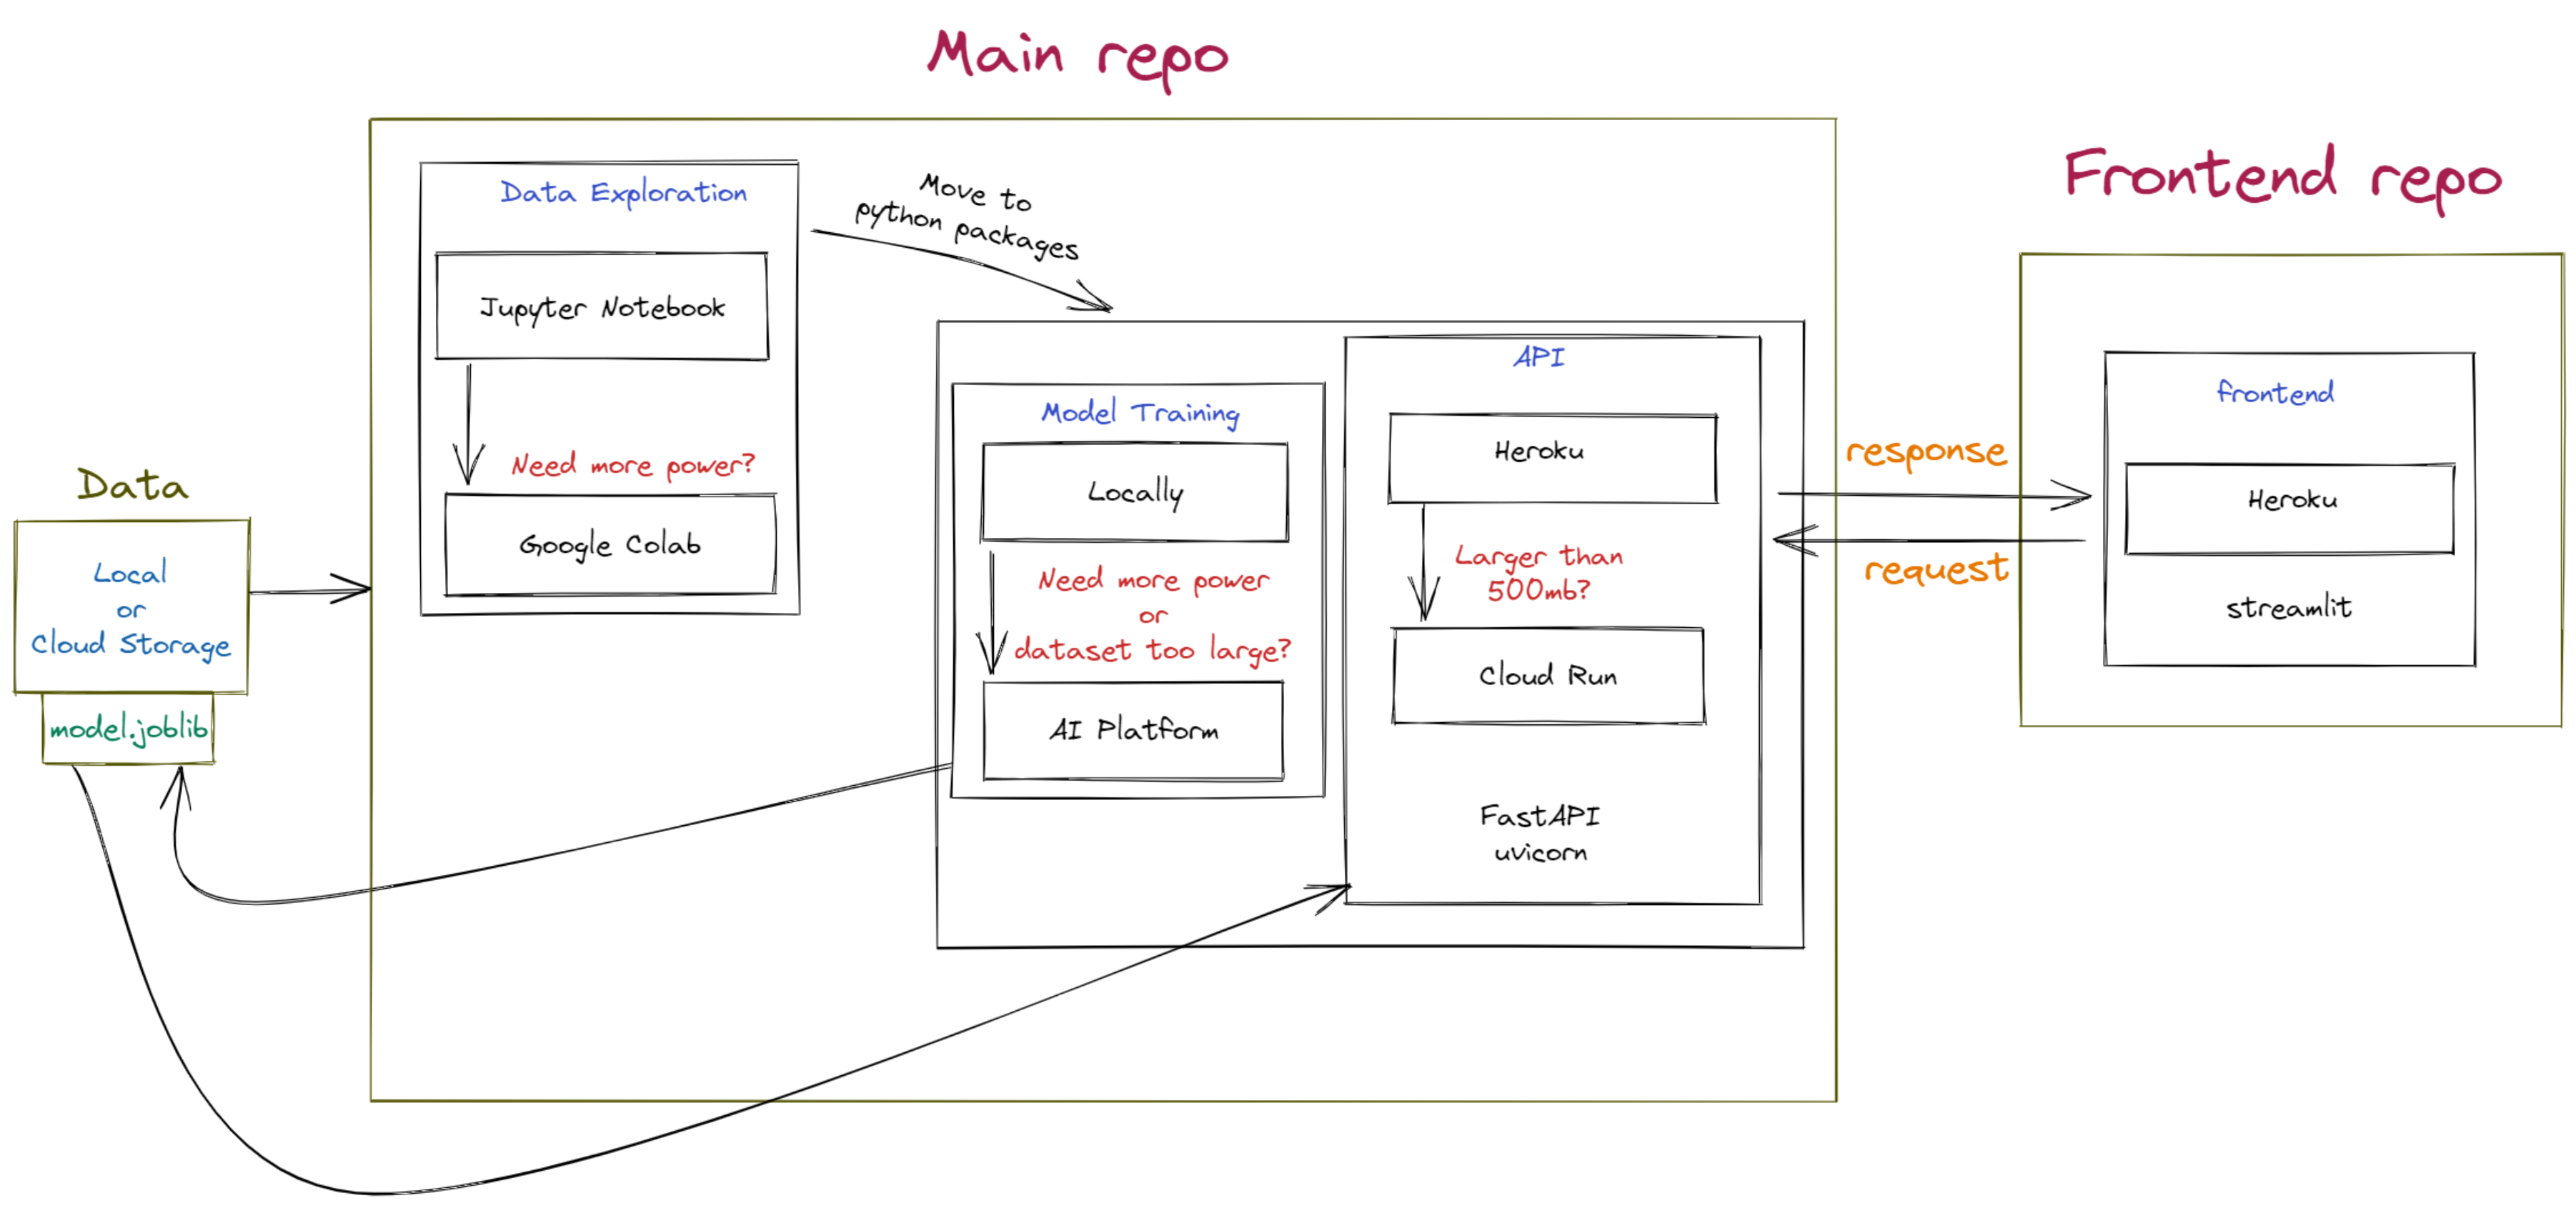

In [9]:
from IPython.display import Image
Image("project_structure.png")